## 单张图片处理流程

整体的思路就是：

1. 读取图片。  
    opencv 图片的保存格式为 BGR。使用 plt 输出时要注意，不然颜色显示不正确；   
    读取 `png` 时也要注意，为此我把素材库都转成了黑底的 `jpg`；   

2. 预剪裁。减小图片大小。  
    根据手工实测 [《Arknights-分辨率与图像比例统计》](https://shimo.im/sheets/vaZbOjW6eJorHQEb/)   
    + 掉落统计下半部分（结算栏）占纵向比例约 0.39  
    + 结算栏中竖分割线上端点，以左上角为原点，横纵坐标相同  
    + 结算栏中竖分割线约在 x 方向的 1/3 处 （不精确；有边框时不准）  
    此步可保留整个结算栏，或者进一步剪裁，只剩下掉落的物品部分  

3. 灰度化。进一步减小图片大小。  
3.2 （可选的）二值化+腐蚀/膨胀。去掉图片的细节，凸显物体整体，便于做物体轮廓识别（物体检测）；  
    进行物体分类时应使用灰度图；  
3.3 （可选的）物体检测。获得物体、文字、分割线等对象的矩形选区。  
    使用 `cv2.findContours` 函数；  
    + 检测出 结算栏中分割线的位置后，能更精确的切割图象；  
    + 检测出 物体的分组线后，可以对物体进行分组（常规掉落、额外掉落...）；  
    + 检测出 物体精确的矩形选取，能单独切割出每一个物体，便于使用其他更高效的算法；  
    TODO: 文字的检测用此方法仍有困难，有待发掘其他方法。     

4. 模板匹配。识别出掉落物体的类型
    使用 `cv2.xfeatures2d.SIFT`: `knnMatch` 算法；  
    使用黑底，无透明度的 `jpg` 物体图片，作为匹配模板；  
    此处可以通过对应的关卡，缩小物体类型的搜索范围，以提高速度；  
    + 关卡编号的获得可以通过上传图片时手工选择，或者进一步做关卡名的识别；  

TODO:
    1. **掉落物体数量的识别**
    2. **关卡名的识别**
    3. 自适应大小图片剪裁；也可以进行交互式物体选取
    4. 提高识别速度
    5. 将尽可能多的处理工作转移到前端，以减小服务器压力

In [1]:
# 导入所需的库

## 必须的依赖
import cv2 # 必备的库。使用其中的算法来做物体识别

## 辅助依赖；
#     TODO：尽可能去掉以下依赖
import os # 用于遍历整个目录
import numpy as np # 用于一些数据转换
import matplotlib.pyplot as plt # 用于在 jupyter 里画图，而不是弹出窗口画图；也用于 png -> jpg 的转换

----

In [2]:
# 0. 辅助函数

def get_img_HW(img): # 获取图像的长宽
    H, W = img.shape[:2] # 长宽
    return (H, W)

def BGR2RGB(img): # BGR 转 RGB，便于 plt 正确输出图像
    assert len(img.shape)==3, "Only support BGR, no gary"
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
def show(img, big=True): # 打印大图
    if big:
        plt.figure(figsize=(20,20)) # 放大图片到与页面同宽
    if len(img.shape)==3: # BGR 图像
        _img = BGR2RGB(img)
        plt.imshow(_img)
    else: # 灰度图像
        _img = img
        plt.imshow(_img, cmap=plt.cm.gray)
    plt.show()

def ss(img): # 打印缩略图
    show(img, big=False)

def get_img_info(filename): # 从文件名中提取信息
    assert isinstance(filename, str), "`filename` should be <str>"
    name, ext = filename.split('.')
    level_name, exp, *info = name.split('+')
    return dict((
        ('ext', ext),
        ('level_name', level_name), 
        ('exp', exp), 
        *(tuple(kv.split('=')) for kv in info)
    ))

# 生成 { 所有物品名 => 文件路径} 的字典
def gen_all_name_path_dict(items_dir_name='item_icon_black'):
    item_dict={}
    for root, dirs, files in os.walk(items_dir_name):
        for name in files:
            (filename1, extension1) = os.path.splitext(name)
            item_dict[filename1] = os.path.join(root, name)
    return item_dict

g_items_dict = gen_all_name_path_dict()

def print_info(img_info): # 输出图片信息，只输出掉落物品的信息
    for k in img_info:
        if k not in ['ext', 'level_name', 'exp', 'STAR']:
            print(k, "=", img_info[k], end=", ")

----

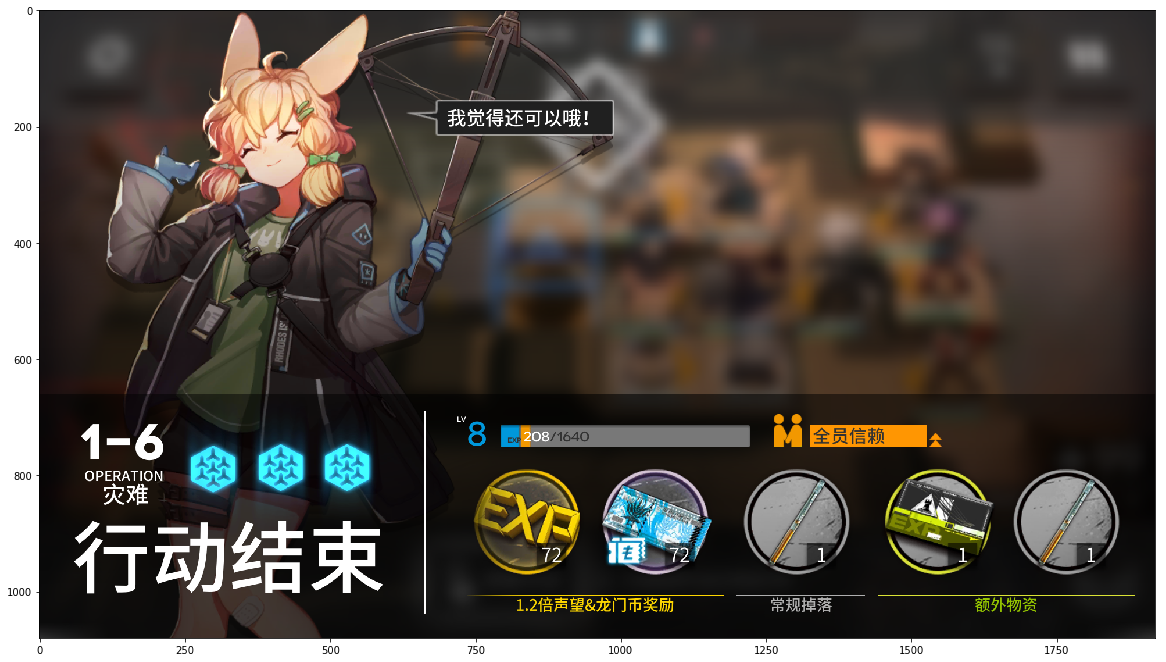

In [3]:
# 1. 读取图片

g_dir_root = 'wos_result/1-ZhuXian/ep1'
g_filename = '1-6+08208+STAR=3+SHUANGTONG=2+JCZZJL=1.png'
g_img_path = os.path.join(g_dir_root, g_filename)

g_img = cv2.imread(g_img_path)
show(g_img)

----

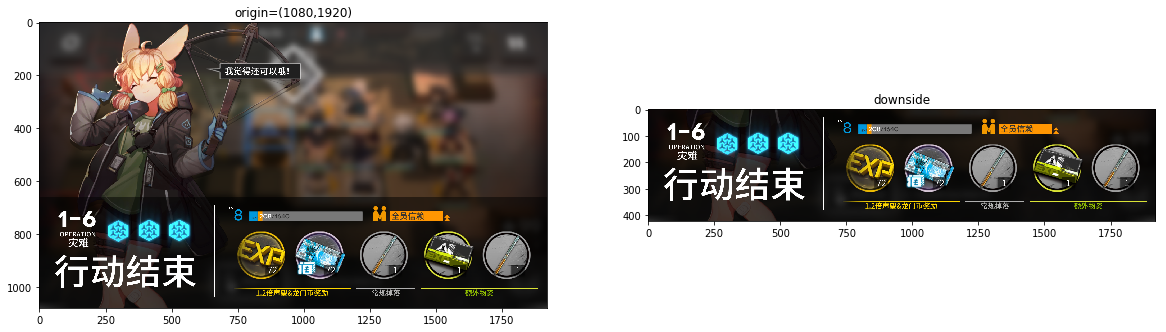

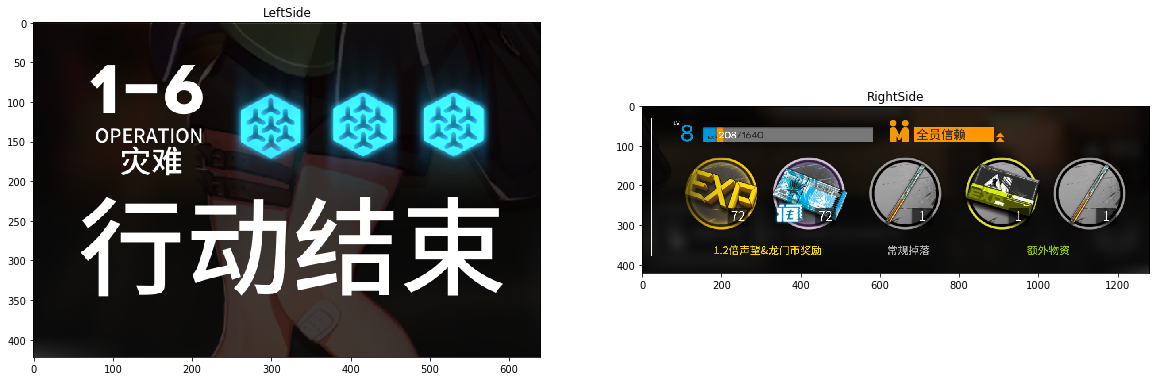

In [4]:
# 2. 预剪裁

def cut_downside(img): # 输入图像矩阵，剪裁出下半部分
    H, W = get_img_HW(img)
    return img[int(H*0.61):, :]

def show_downside(img):
    img = BGR2RGB(img)
    H, W = get_img_HW(img)
    down_side = cut_downside(img)
    
    plt.figure(figsize=(20,20))
    plt.subplot(121); plt.title("origin=({0},{1})".format(H,W))
    plt.imshow(img)
    plt.subplot(122); plt.title("downside")
    plt.imshow(down_side)
    plt.show()

# 下半部分，预剪裁效果 （精确）
g_downside = cut_downside(g_img)
gH, gW = get_img_HW(g_downside)
show_downside(g_img)


# ----
# 切出掉落区域（近似）

def cut_drops(downside_img): # 剪裁出掉落物品的区域
    _, W = get_img_HW(downside_img) # 长宽
    return (downside_img[:, :int(W/3)], downside_img[:, int(W/3):])

def show_drops(img):
    img = BGR2RGB(img)
    H, W = get_img_HW(img)
    down_side = cut_downside(img)
    star, drops = cut_drops(down_side)

    plt.figure(figsize=(20,20))
    plt.subplot(121); plt.title("LeftSide");
    plt.imshow(star)
    plt.subplot(122); plt.title("RightSide");
    plt.imshow(drops)
    plt.show()

# 进一步剪裁出右侧掉落物品栏 （不精确）
g_itemside = cut_drops(g_downside)
show_drops(g_img)

----

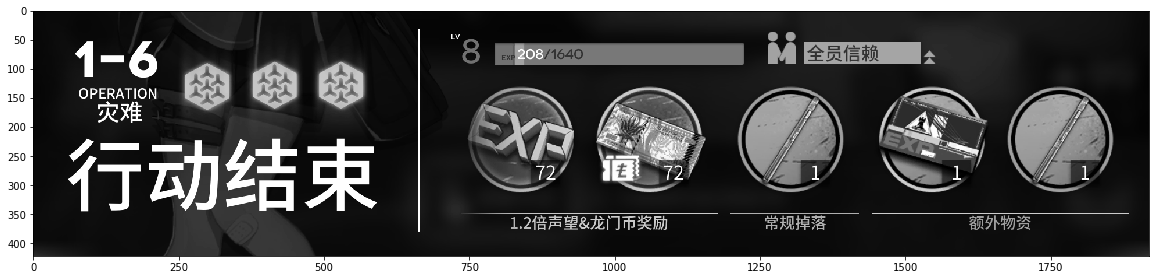

In [5]:
# 3. 灰度化

def get_gray_img(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

g_downside_gray = get_gray_img(g_downside)
show(g_downside_gray)

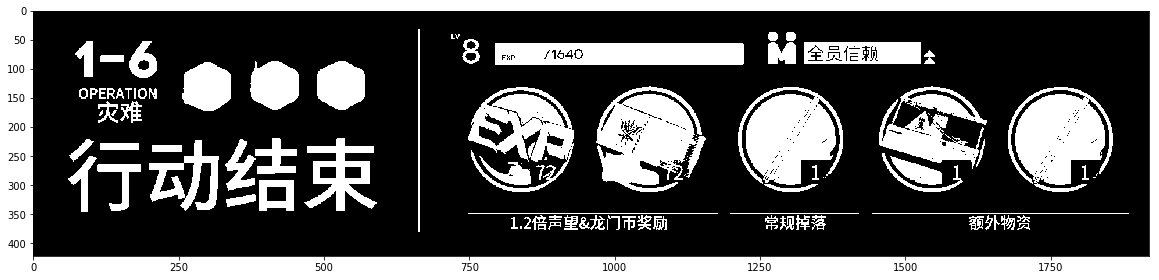

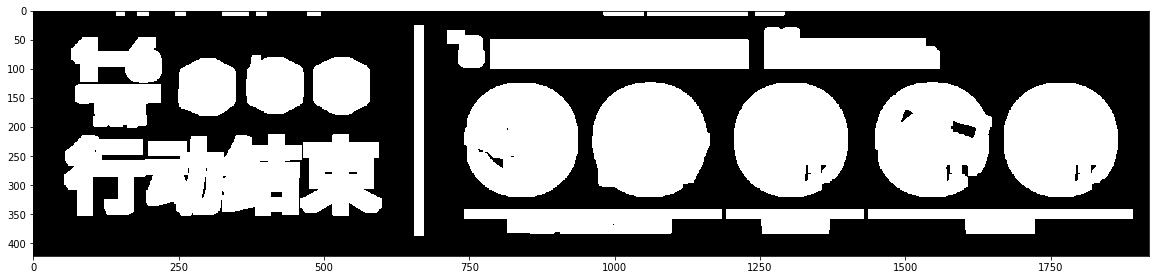

In [6]:
# 3.2 （可选的）二值化+腐蚀/膨胀

def get_binary_img(gray_img): # 二值化，必须输入灰度图像
    ret, binary = cv2.threshold(gray_img, 64, 255, cv2.THRESH_BINARY)
    return binary

g_downside_binary = get_binary_img(g_downside_gray)
show(g_downside_binary)


# 膨胀与腐蚀
def PengZhang(binary_img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(16,16))
    return cv2.dilate(binary_img, kernel)

g_downside_dilate = PengZhang(g_downside_binary)
show(g_downside_dilate)

all Contours = 51
H:W = 116.0
(spX, spY, spW, spH) = (662, 32, 3, 348)


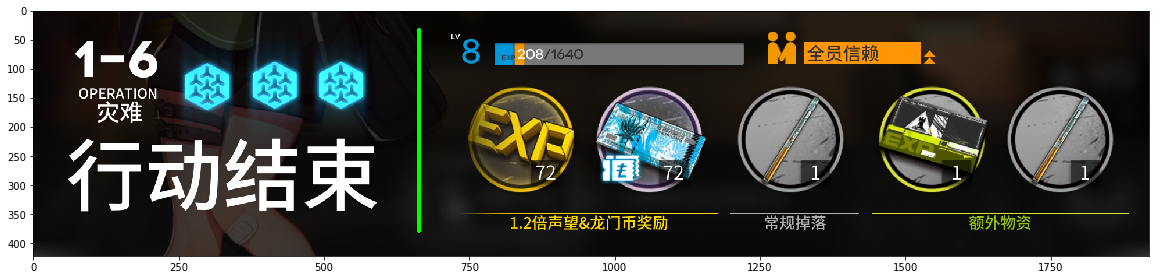

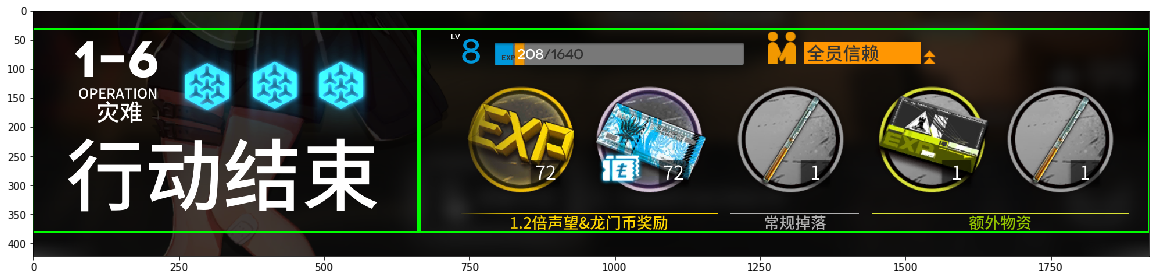

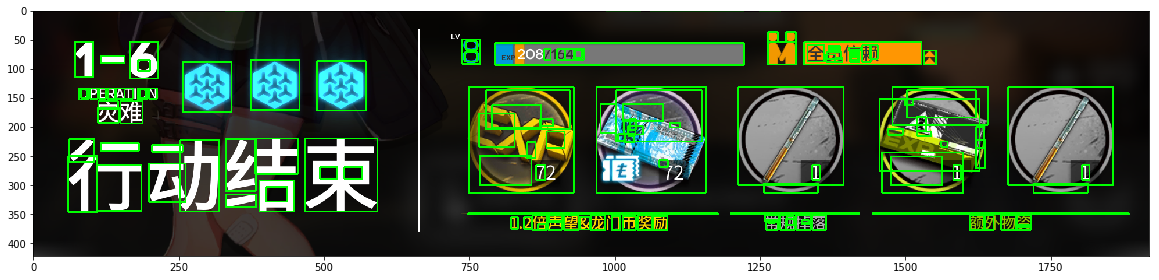

In [7]:
# 3.3 （可选的）物体检测

def get_boxes(img):
    (_, cnts, _) = cv2.findContours(
        img.copy(),
        cv2.RETR_LIST, # 无层次
        cv2.CHAIN_APPROX_SIMPLE
    )
    return cnts

g_box_dilate = get_boxes(g_downside_dilate)
g_box = get_boxes(g_downside_binary)

# --------------------
# 绘制仅二值化的识别结果
print("all Contours =", np.size(g_box_dilate)) # 打印检测到的物体个数

_tmp331_origin_img = g_downside.copy() # 在彩色底图上绘制
spX, spY, spW, spH = (0,0,0,0) # 分割线坐标
for cnt in g_box:
    rect = cv2.boundingRect(cnt)
    x, y, w, h = rect  # 得到盒子的位置信息
    hw = h / w         # 计算高宽比
    if (w>10): # 显示所有的物体;滤除较小的
        cv2.rectangle(_tmp331_origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    if (10 < hw): # 寻找分割线；用高宽比判断
        print("H:W =", hw)
        spX, spY, spW, spH = rect
        print("(spX, spY, spW, spH) =", rect)
        _tmp332_draw_img=g_downside.copy() # 在彩色底图上绘制
        cv2.rectangle(_tmp332_draw_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # 定位用分割线
        show(_tmp332_draw_img)
        cv2.rectangle(_tmp332_draw_img, (0, y), (gW, y+h), (0, 255, 0), 2) # 取分割线上下界
        show(_tmp332_draw_img)
show(_tmp331_origin_img) 


W:H = 220.50 ;	 (x, y, w, h) = (1444, 348, 441, 2)
W:H = 110.50 ;	 (x, y, w, h) = (1200, 348, 221, 2)
W:H = 215.00 ;	 (x, y, w, h) = (748, 348, 430, 2)


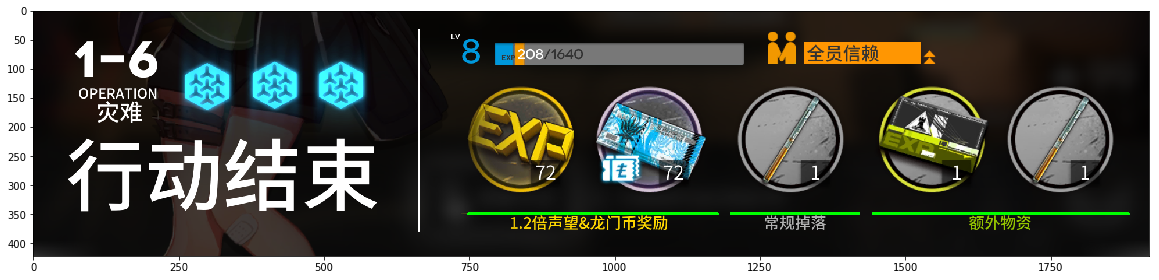

H:W = 1.00 ;	 (x, y, w, h) = (1670, 125, 196, 196)
H:W = 1.00 ;	 (x, y, w, h) = (1206, 125, 196, 196)
H:W = 1.00 ;	 (x, y, w, h) = (742, 125, 196, 196)
H:W = 0.98 ;	 (x, y, w, h) = (1449, 124, 201, 197)
H:W = 0.97 ;	 (x, y, w, h) = (962, 124, 203, 197)


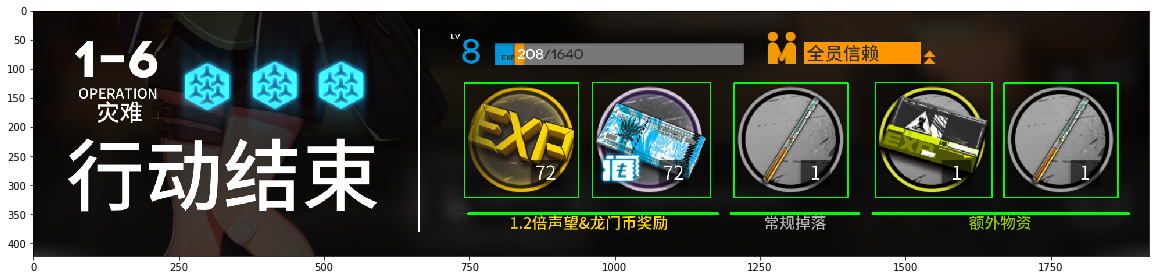

In [8]:
# 寻找 分组标志与掉落物体

_tmp341_origin_img = g_downside.copy()
g_drop_items_box = []
g_drop_group = []

# 使用二值化的图像结果，添加分组标记
for cnt in g_box:
    rect = cv2.boundingRect(cnt)
    x, y, w, h = rect
    hw = float(h) / w
    if (1/hw > 20) \
        and (3*w>spH) \
        and (x > spX)  and (y > spY):
        print("W:H = %.2f" % (1/hw), ";\t (x, y, w, h) =", rect)
        g_drop_group += (rect,)
        cv2.rectangle(_tmp341_origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # 物体分组

show(_tmp341_origin_img)

# 使用二值化+膨胀的结果，识别掉落的物品
g_num_of_items = 0
for cnt in g_box_dilate:
    rect = cv2.boundingRect(cnt)
    x, y, w, h = rect
    hw = float(h) / w
    if (0.95 <hw) and (hw<1.08) \
        and (2*h >spH) and (2*w>spH) \
        and (x > spX)  and (y > spY):
        g_num_of_items += 1
        print("H:W = %.2f" % hw, ";\t (x, y, w, h) =", rect)
        g_drop_items_box += (rect,)
        cv2.rectangle(_tmp341_origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # 掉落的物体

show(_tmp341_origin_img)

In [9]:
# 对物体进行分组

def group_items(drop_items, drop_group):
    ## 从左到右排序（按 X 增大排序)
    drop_items.sort(key=lambda t: t[0])
    drop_group.sort(key=lambda t: t[0])
    
    _items = drop_items.copy()
    grouped_items = []
    
    for g in drop_group:
        gx, gy, gw, gh = g
        gXmin, gXmax = gx, gx+gw
        print("gXmin, gXmax =", gXmin, gXmax)
        _tmp_g=[]
        
        while _items:
            x, y, w, h = _items[0]
            ctX, ctY = x+w*0.5, y+h*0.5
            if (gXmin<= ctX <=gXmax):
                _tmp_g += (_items[0],)
                _items.pop(0)
            elif (x>gXmax) or (x<gXmin):
                break
        
        grouped_items += [_tmp_g]
    
    return grouped_items

grouped_items = group_items(g_drop_items_box, g_drop_group)
print(grouped_items)
print("共分为{0}组".format(len(grouped_items)))

gXmin, gXmax = 748 1178
gXmin, gXmax = 1200 1421
gXmin, gXmax = 1444 1885
[[(742, 125, 196, 196), (962, 124, 203, 197)], [(1206, 125, 196, 196)], [(1449, 124, 201, 197), (1670, 125, 196, 196)]]
共分为3组


(x, y, w, h) = (742, 125, 196, 196)
(x, y, w, h) = (962, 124, 203, 197)
(x, y, w, h) = (1206, 125, 196, 196)
(x, y, w, h) = (1449, 124, 201, 197)
(x, y, w, h) = (1670, 125, 196, 196)


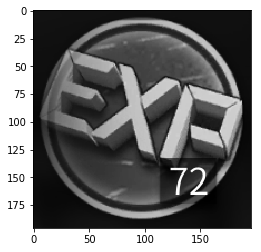

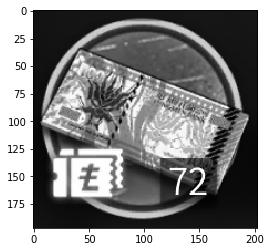

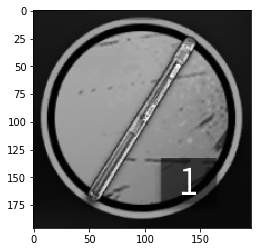

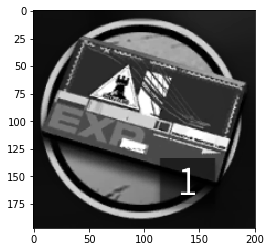

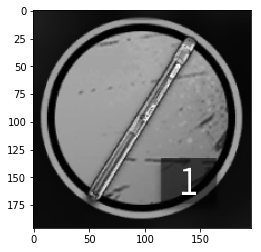

In [10]:
# 单独切割出每一个物体

def cut_items(drop_items, origin_img):
    items = []
    for item in drop_items:
        x, y, w, h = item
        print("(x, y, w, h) =", item)
        items += [ origin_img[y:(y+h), x:(x+w)] ]
    return items

g_items = cut_items(g_drop_items_box, g_downside_gray)
for i in g_items:
    ss(i)

----

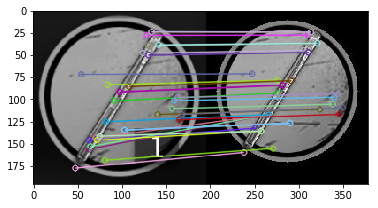

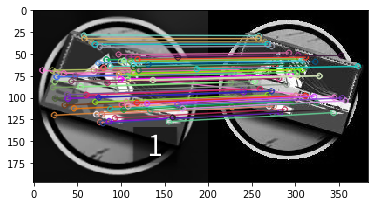

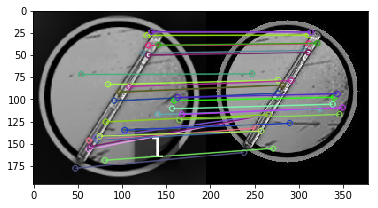

['shuangtong', 'jczzjl', 'shuangtong']
SHUANGTONG = 2, JCZZJL = 1, 

In [11]:
# 4. 模板匹配

img_info = get_img_info(g_filename)

# 根据关卡名，缩小掉落物品范围
possible_drop_items = [
    'jczzjl', 'chijin',  # 基础作战记录，赤金
    'yuanyan', 'pszz',   # 原岩，破碎装置
    'zyl', 'daitang',    # 酯原料，代糖
    'ytsp', 'shuangtong' # 异铁碎片，双酮
] # T1

g_drop_items_set = [(i, g_items_dict[i]) for i in possible_drop_items]


# 匹配掉落物品
# img1 = cv2.imread('Mavic Air Fly.jpeg')

def init_match(drop_items_set):
    # SIFT 算法初始化
    sift = cv2.xfeatures2d.SIFT_create()
    bfm = cv2.BFMatcher_create(normType=cv2.NORM_L2, crossCheck=False)
    
    # 预制备匹配模板图片
    gray_items = []
    for (name, path) in drop_items_set:
        img = cv2.imread(path)
        grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(grayImg, None)
        gray_items += [(name, grayImg, kp, des)]
    
    return sift, bfm, gray_items


def match_items(
    target_imgs,
    drop_items_set,
    PRINT_IMG=False,
    MIN_MATCH_COUNT = 10 # 这个参数需要仔细微调。
):
    match_result = []
    sift, bfm, gray_items = init_match(drop_items_set)
    
    for img in target_imgs:
        kp1, des1 = sift.detectAndCompute(img, None)
        
        for item_name, grayImg, kp2, des2 in gray_items:
            matches = bfm.knnMatch(des1, des2, k=2)
            
            # 使用阈值筛选距离
            good_match = []
            for m, n in matches:
                if m.distance < 0.6*n.distance:
                    good_match.append([m])
            if len(good_match) > MIN_MATCH_COUNT:
                match_result.append(item_name)
                if PRINT_IMG:
                    matchImg = np.zeros_like(img)
                    matchImg = cv2.drawMatchesKnn(img, kp1, grayImg, kp2, good_match, matchImg, flags=2)
                    ss(matchImg)
    return match_result

match_result = match_items(g_items, g_drop_items_set, PRINT_IMG=True, MIN_MATCH_COUNT = 20)
print(match_result)  # 识别的结果
print_info(img_info) # 正确的结果

----

In [ ]:
# 显示从指定图片中切出的掉落物品
def get_items(path):
    img = cv2.imread(path)
#     show(img)
    downside = cut_downside(img)
    gH, gW = get_img_HW(downside)
#     show_downside(img)
    downside_gray = get_gray_img(downside)
#     show(downside_gray)
    downside_binary = get_binary_img(downside_gray)
#     show(downside_binary)
    downside_dilate = PengZhang(downside_binary)
#     show(downside_dilate)
    box_dilate = get_boxes(downside_dilate)
    box = get_boxes(downside_binary)
    _tmp331_origin_img = downside.copy() # 在彩色底图上绘制
    spX, spY, spW, spH = (0,0,0,0) # 分割线坐标
    for cnt in box:
        rect = cv2.boundingRect(cnt)
        x, y, w, h = rect  # 得到盒子的位置信息
        hw = h / w         # 计算高宽比
        if (w>10): # 显示所有的物体;滤除较小的
            cv2.rectangle(_tmp331_origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        if (10 < hw): # 寻找分割线；用高宽比判断
#             print("H:W =", hw)
            spX, spY, spW, spH = rect
#             print("(spX, spY, spW, spH) =", rect)
            _tmp332_draw_img=downside.copy() # 在彩色底图上绘制
            cv2.rectangle(_tmp332_draw_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # 定位用分割线
#             show(_tmp332_draw_img)
            cv2.rectangle(_tmp332_draw_img, (0, y), (gW, y+h), (0, 255, 0), 2) # 取分割线上下界
#             show(_tmp332_draw_img)
#     show(_tmp331_origin_img) 
    _tmp341_origin_img = downside.copy()
    drop_items_box = []
    drop_group = []

    # 使用二值化的图像结果，添加分组标记
    for cnt in box:
        rect = cv2.boundingRect(cnt)
        x, y, w, h = rect
        hw = float(h) / w
        if (1/hw > 20) \
            and (3*w>spH) \
            and (x > spX)  and (y > spY):
#             print("W:H = %.2f" % (1/hw), ";\t (x, y, w, h) =", rect)
            drop_group += (rect,)
            cv2.rectangle(_tmp341_origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # 物体分组

#     show(_tmp341_origin_img)

    # 使用二值化+膨胀的结果，识别掉落的物品
    num_of_items = 0
    for cnt in box_dilate:
        rect = cv2.boundingRect(cnt)
        x, y, w, h = rect
        hw = float(h) / w
        if (0.95 <hw) and (hw<1.08) \
            and (2*h >spH) and (2*w>spH) \
            and (x > spX)  and (y > spY):
            num_of_items += 1
#             print("H:W = %.2f" % hw, ";\t (x, y, w, h) =", rect)
            drop_items_box += (rect,)
            cv2.rectangle(_tmp341_origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # 掉落的物体

#     show(_tmp341_origin_img)
    items = cut_items(drop_items_box, downside_gray)
    for i in items:
        ss(i)

# 遍历某个目录
for root, dirs, files in os.walk('others_drop_result/1-ZhuXian/ep4'):
    for name in files:
        (filename1, extension1) = os.path.splitext(name)
        path = os.path.join(root, name)
        print(path)
        get_items(path)
